### Pretraining on unlabeled data

#### 5.1 Evaluating generative text models

##### 5.1.1 Using GPT to generate text

In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow"
]

for p in pkgs:
    print(f"{p} version: ${version(p)}")

matplotlib version: $3.10.3
numpy version: $2.0.2
tiktoken version: $0.9.0
torch version: $2.7.0
tensorflow version: $2.19.0


In [2]:
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [3]:
import torch

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [4]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    
    
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = text_to_token_ids(start_context, tokenizer=tokenizer)
print(token_ids)

origin_text = token_ids_to_text(token_ids, tokenizer)

print(origin_text)
    

tensor([[6109, 3626, 6100,  345]])
Every effort moves you


In [5]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

token_ids.squeeze(0).shape
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you rentingetic wasnم refres RexMeCHicular stren'

##### 5.1.2 Calculating the text generation loss: cross entropy and perplexity

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [7]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [8]:
flat_probas = probas.flatten(0, 1)
print(flat_probas.shape)
flat_targets = targets.flatten()
print(flat_targets)

torch.Size([6, 50257])
tensor([ 3626,  6100,   345,  1107,   588, 11311])


In [9]:
target_probas = flat_probas[[0, 1, 2, 3, 4, 5], flat_targets]

loss = -torch.log(target_probas).mean()

print(loss)

tensor(10.7940)


In [10]:
logits_flat = logits.flatten(0, 1)

loss = torch.nn.functional.cross_entropy(logits_flat, flat_targets)
print(loss)

perplexity = torch.exp(loss)
print(perplexity)

tensor(10.7940)
tensor(48725.8203)


##### 5.1.3 计算训练集和验证集的损失

In [11]:
file_path = "../my_ch02/the-verdict.txt"

with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
    
print(len(text_data))

token_ids = tokenizer.encode(text=text_data)

print(len(token_ids))

20479
5145


In [12]:
from previous_chapters import create_dataloader_v1

train_ratio = 0.90

split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print("length of train_data: ", len(train_data))
print("length of val_data: ", len(val_data))

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    txt=train_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"],
    shuffle=True, drop_last=True, num_workers=0
)

val_loader = create_dataloader_v1(
    txt=val_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"],
    shuffle=False, drop_last=False, num_workers=0
)

print("Train loader shape:")
for x, y in train_loader:
    print(x.shape, y.shape)
    
print("Val loader shape:")

for x, y in val_loader:
    print(x.shape, y.shape)

length of train_data:  18431
length of val_data:  2048
Train loader shape:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Val loader shape:
torch.Size([2, 256]) torch.Size([2, 256])


In [13]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)
    
    return torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    

def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input, target) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input, target, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
    
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583690219456
Validation loss: 10.98110580444336


#### 5.2 训练大语言模型

In [14]:
torch.mps.is_available()

def evaluate_a_model(
    model, train_loader, val_loader, device, eval_iter
):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
        
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded, max_new_tokens=50, context_size=context_size)
        
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, tract_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            
            optimizer.step()
            
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_a_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                tract_tokens_seen.append(tokens_seen)
                
                print(
                    f"Ep {epoch + 1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, tract_tokens_seen

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, start_context="Every effort moves you",
    tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

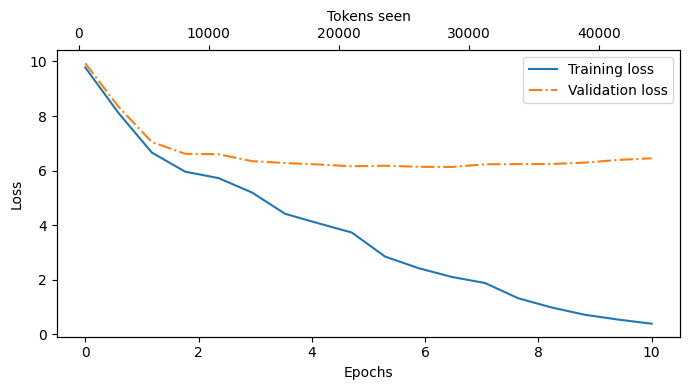

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.plot(
        epochs_seen, train_losses, label="Training loss"
    )
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    
    fig.tight_layout()
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#### 5.3 控制随机性解码策略

In [16]:
model.to("cpu")
model.eval() # 非训练模式

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=30,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(f"Output text:\n {token_ids_to_text(token_ids, tokenizer)}")

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when


In [17]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {
    v: key for key, v in vocab.items()
}

inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [18]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

torch.set_printoptions(sci_mode=False)

probas = torch.softmax(next_token_logits, dim=0)
print(probas)

tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])


In [19]:
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

forward


In [20]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [21]:
def print_sampled_tokens(probas):
    next_token_ids = [torch.multinomial(probas, num_samples=1).item() for _ in range(1000)]
    
    sample_ids = torch.bincount(torch.tensor(next_token_ids))
    
    for i, count in enumerate(sample_ids):
        print(f"{count} x ${inverse_vocab[i]}")

torch.manual_seed(123)
print_sampled_tokens(probas)
        

73 x $closer
0 x $every
0 x $effort
582 x $forward
2 x $inches
0 x $moves
0 x $pizza
343 x $toward


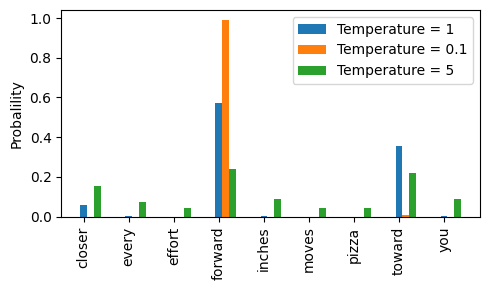

In [22]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))

bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f"Temperature = {T}")
    
ax.set_ylabel("Probalility")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

##### 5.3.2 Top-k 采样

In [23]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top logits position:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top logits position: tensor([3, 7, 0])


In [24]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [25]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


##### 5.3.3 修改文本生成函数

In [26]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_k_probas, _ = torch.topk(logits, top_k)
            min_val = top_k_probas[:, -1]

            logits = torch.where(
                logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits
            )
            
        if temperature > 0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

torch.manual_seed(123)
token_ids = generate(
    model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

Output text:
Every effort moves you stand to work on surprise, a one of us had gone with random-


#### 5.4 使用pytorch 加载和保存模型权重

In [27]:
torch.save(model.state_dict(), "model.pth")

In [28]:
model2 = GPTModel(GPT_CONFIG_124M)
model2.load_state_dict(torch.load("model.pth", map_location=device))
model2.eval()

torch.manual_seed(123)
token_ids = generate(
    model2,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

Output text:
Every effort moves you stand to work on surprise, a one of us had gone with random-


In [29]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, "model_and_optimizer.pth")

In [30]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model3 = GPTModel(GPT_CONFIG_124M)
model3.load_state_dict(checkpoint["model_state_dict"])
optimizer3 = torch.optim.AdamW(model3.parameters(), lr=5e-4, weight_decay=0.1)
optimizer3.load_state_dict(checkpoint["optimizer_state_dict"])

torch.manual_seed(123)
token_ids = generate(
    model3,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

Output text:
Every effort moves youlit terrace.



" he said deprecating laugh


#### 5.5 从 OpenAI 加载预训练权重

In [32]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x47557c090>)

In [ ]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="124M",
    models_dir="gpt2"
)

print("Setting:", settings)
print("Parameter dictionary keys:", params.keys())

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 11.8kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.42MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 49.1kiB/s]
model.ckpt.data-00000-of-00001:  31%|███▏      | 1.96G/6.23G [1:16:41<2:47:27, 425kiB/s]  
model.ckpt.index: 100%|██████████| 20.7k/20.7k [00:00<00:00, 4.00MiB/s]
model.ckpt.meta: 100%|██████████| 1.84M/1.84M [00:00<00:00, 2.15MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 944kiB/s] 


IndexError: Read less bytes than requested

In [ ]:
import numpy as np


model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-xl (1558M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({
    "context_length": 1024
})
NEW_CONFIG.update({
    "qkv_bias": True
})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
load_weights_into_gpt(gpt, params)
gpt.to(device)

torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=100,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?

As much as our intuition makes us try a lot, that intuitive part goes unchanging and changes over time. A new aspect becomes very attractive and makes up for our limitations. It helps explain our goals we'd like us to hold more strongly after their success has already led us to success.<|endoftext|>Pretend that all you learned from that college prep class that night is the


In [40]:
evaluate_a_model(
    gpt,
    train_loader,
    val_loader,
    device,
    eval_iter=5
)

(3.8106240749359133, 3.5596015453338623)